<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: Application to quantum chemistry*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Antonio Mezzacapo, Jay Gambetta

### Introduction

One of the most compelling possibilities of quantum computation is the the simulation of other quantum systems. Quantum simulation of quantum systems encompasses a wide range of tasks, including most significantly:
    
1. Simulation of the time evolution of quantum systems.

2. Computation of ground state properties. 

These applications are especially useful when considering systems of interacting fermions, such as molecules and strongly correlated materials. The computation of ground state properties of fermionic systems is the starting point for mapping out the phase diagram of condensed matter Hamiltonians. It also gives access to the key question of electronic structure problems in quantum chemistry, namely reaction rates. The focus of this notebook is on molecular systems, which are considered to be the ideal bench test for early-stage quantum computers, due to their relevance in chemical applications despite relatively modest sizes. Formally, the ground state problem asks the following:

For some physical Hamiltonian *H*, find the smallest eigenvalue $E_G$, such that $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $|\Psi_G\rangle$ is the eigenvector corresponding to $E_G$.
    
It is known that in general this problem is intractable, even on a quantum computer. This means that we cannot expect an efficient quantum algorithm that prepares the ground state of general local Hamiltonians. Despite this limitation, for specific Hamiltonians of interest it might be possible, given physical constraints on the interactions, to solve the above problem efficiently. Currently, at least four different methods exist to approach this problem:

1. Quantum phase estimation: Assuming that we can approximately prepare the state $|\psi_G\rangle$, this routine uses controlled implementations of the Hamiltonian to find its smallest eigenvalue. 
2. Adiabatic theorem of quantum mechanics: The quantum system is adiabatically dragged from being the ground state of a trivial Hamiltonian to the one of the target problem, via slow modulation of the Hamiltonian terms. 
3. Dissipative (non-unitary) quantum operation: The ground state of the target system is a fixed point. The non-trivial assumption here is the implementation of the dissipation map on quantum hardware. 
4. Variational quantum eigensolvers: Here we assume that the ground state can be represented by a parameterization containing a relatively small number of parameters.

In this notebook we focus on the last method, as this is most likely the simplest to be realized on near-term devices. 

The general idea is to define a parameterization $|\psi(\boldsymbol\theta)\rangle$ of quantum states, and minimize the energy 

$$E(\boldsymbol\theta) = \langle \psi(\boldsymbol\theta)| H |\psi(\boldsymbol\theta)\rangle,$$ 

The key ansatz is that the number of parameters $|\boldsymbol\theta^*|$ that minimizes the energy function scales polynomially with the size (e.g., number of qubits) of the target problem.  

Then, any local fermionic Hamiltonian can be mapped into a sum over Pauli operators $P_i$,  

$$H\rightarrow H_P = \sum_i^M w_i P_i,$$ 

and the energy corresponding to the state $|\psi(\boldsymbol\theta\rangle$, $E(\boldsymbol\theta)$, can be estimated by sampling the individual Pauli terms $P_i$ (or sets of them that can be measured at the same time) on a quantum computer

$$E(\boldsymbol\theta) = \sum_i^M w_i \langle \psi(\boldsymbol\theta)| P_i |\psi(\boldsymbol\theta)\rangle.$$ 

Last, some optimization technique has to be devised in order to find the optimal value of parameters $\boldsymbol\theta^*$, such that $|\psi(\boldsymbol\theta^*)\rangle\equiv|\psi_G\rangle$.



### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} t_{\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} u_{\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ t_{\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ u_{\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

### Molecules considered in this notebook and mapping to qubits

We consider in this notebook the optimization of two potential energy surfaces, for the hydrogen and lithium hydride molecules, obtained using the STO-3G basis. The molecular Hamiltonians are computed as a function of their interatomic distance, then mapped to two- (H$_2$) and four- (LiH$_2$) qubit problems, via elimination of core and high-energy orbitals and removal of $Z_2$ symmetries.

### Approximate universal quantum computing for quantum chemisty problems

In order to find the optimal parameters $\boldsymbol\theta^*$, we set up a closed optimization loop with a quantum computer, based on some stochastic optimization routine. Our choice for the variational ansatz is a deformation of the one used for the optimization of classical combinatorial problems, with the inclusion of $Z$ rotation together with the $Y$ ones. The optimization algorithm for fermionic Hamiltonians is similar to the one for combinatorial problems, and can be summarized as follows: 


1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth of the quantum circuit (this could be done adaptively).
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. The difference with the combinatorial problems is the insertion of additional parametrized $Z$ single-qubit rotations.
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms that can be measured in the same tensor product basis.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$ and return the last value of $E(\boldsymbol\theta)$.
    

Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage of using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we also define a variational trial ansatz in this way: 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit $Y$ and $Z$ rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit. 



References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017), and references therein.


In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
from functools import partial

# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ryrz, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Hamiltonian_from_file, make_Hamiltonian
from qiskit.tools.apps.optimization import eval_hamiltonian, group_paulis

# Ignore warnings due to chopping of small imaginary part of the energy 
import warnings
warnings.filterwarnings('ignore')
                

## Optimization of H2 at bond length

In this first part of the notebook we show the optimization of the H$_2$ Hamiltonian in the STO-3G basis at the bond length of 0.735 Angstrom. After mapping it to a four-qubit system with a binary-tree transformation, two spin-parity symmetries are modded out, leading to a two-qubit Hamiltonian. The energy of the mapped Hamiltonian obtained is then minimized using the variational ansatz described in the introduction, and a stochastic perturbation simultaneous approximation (SPSA) gradient descent method. 

In [2]:
n=2
m=6
device='local_qasm_simulator'

initial_theta=np.random.randn(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=100
ham_name='H2/H2Equilibrium.txt'

# Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
print('The exact ground state energy is:')
print(exact)
pauli_list_grouped=group_paulis(pauli_list)

# Optimization
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])



def cost_function(Q_program,H,n,m,entangler_map,shots,device,theta):
    
    return eval_hamiltonian(Q_program,H,trial_circuit_ryrz(n,m,theta,entangler_map,None,False),shots,device).real


initial_c=0.01
target_update=2*np.pi*0.1
save_step = 20

if shots ==1:
    SPSA_params=SPSA_calibration(partial(cost_function,Q_program,H,n,m,entangler_map,
                                         shots,device),initial_theta,initial_c,target_update,25)
    output=SPSA_optimization(partial(cost_function,Q_program,H,n,m,entangler_map,shots,device),
                         initial_theta,SPSA_params,max_trials,save_step,1);
else:
    SPSA_params=SPSA_calibration(partial(cost_function,Q_program,pauli_list_grouped,n,m,entangler_map,
                                         shots,device),initial_theta,initial_c,target_update,25)
    output=SPSA_optimization(partial(cost_function,Q_program,pauli_list_grouped,n,m,entangler_map,shots,device),
                         initial_theta,SPSA_params,max_trials,save_step,1);



The exact ground state energy is:
-1.8572746705
calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.23587343356
objective function at theta+ for step # 0
-1.12184334801
objective function at theta- for step # 0
-1.13210224717
objective function at theta+ for step # 20
-1.35606481784
objective function at theta- for step # 20
-1.36663521809
objective function at theta+ for step # 40
-1.8133659706
objective function at theta- for step # 40
-1.81514145739
objective function at theta+ for step # 60
-1.85052903197
objective function at theta- for step # 60
-1.84626633243
objective function at theta+ for step # 80
-1.85681616062
objective function at theta- for step # 80
-1.85686130312
Final objective function is: -1.85727338303


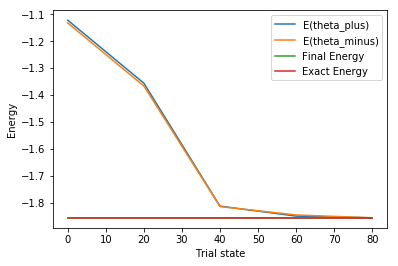

In [3]:
plt.plot(np.arange(0, max_trials,save_step),output[2],label='E(theta_plus)')
plt.plot(np.arange(0, max_trials,save_step),output[3],label='E(theta_minus)')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*output[0],label='Final Energy')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

## Optimizing the potential energy surface 

The optimization considered previously is now performed for two molecules, H$_2$ and LiH, for different interatomic distances, and the correspoding nuclei Coulomb repulsion is added in order to obtain a potential energy surface. 

In [4]:
# MOLECULE PARAMETERS

molecule='H2' # name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
# OPTIMIZATION PARAMETERS 

run_optimization=True # Choose True or False. False just plots the exact potential energy surface

def cost_function(Q_program,H,n,m,entangler_map,shots,device,theta):
    
    return eval_hamiltonian(Q_program,H,trial_circuit_ryrz(n,m,theta,entangler_map,None,False),shots,device).real


m=3 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
initial_theta=np.random.randn(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=200

initial_c = 0.01
target_update = 2*np.pi*0.1
save_step = 250 #Setting larger than max_trials to suppress the output at every function call

####################     COMPUTING THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

for i in range(number_of_points):

    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic Molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        H=make_Hamiltonian(pauli_list)
        pauli_list_grouped = group_paulis(pauli_list)
        eigen=la.eig(H)
        electr_energy[i]=np.amin(eigen[0])
           
    # optimization
    
        if run_optimization:
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE ' + str(mol_distance[i]) + ' ANGSTROM\n')
            
            
            if shots !=1:
                H=group_paulis(pauli_list)
         
        
            SPSA_params = SPSA_calibration(partial(cost_function,Q_program,H,n,m,entangler_map,
                                           shots,device),initial_theta,initial_c,target_update,25)
            
            electr_energy_optimized[i] = SPSA_optimization(partial(cost_function,Q_program,H,n,m,entangler_map,shots,device),
                                                           initial_theta,SPSA_params,max_trials,save_step,1)[0];

    
    


OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.13570872082
objective function at theta+ for step # 0
-0.515095690817
objective function at theta- for step # 0
-0.525349069681
Final objective function is: -2.48741365446

OPTIMIZING HAMILTONIAN # 1 AT INTERATOMIC DISTANCE 0.3 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.22663644505
objective function at theta+ for step # 0
-0.638388485733
objective function at theta- for step # 0
-0.644002581478
Final objective function is: -2.36572817518

OPTIMIZING HAMILTONIAN # 2 AT INTERATOMIC DISTANCE 0.4 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
ca

calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 2.62223550753
objective function at theta+ for step # 0
-0.736926995216
objective function at theta- for step # 0
-0.733305040755
Final objective function is: -1.17827133761

OPTIMIZING HAMILTONIAN # 21 AT INTERATOMIC DISTANCE 2.3 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 3.23246307832
objective function at theta+ for step # 0
-0.717016529988
objective function at theta- for step # 0
-0.720431849214
Final objective function is: -1.16666728759

OPTIMIZING HAMILTONIAN # 22 AT INTERATOMIC DISTANCE 2.4 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 2.91416605273
objective function

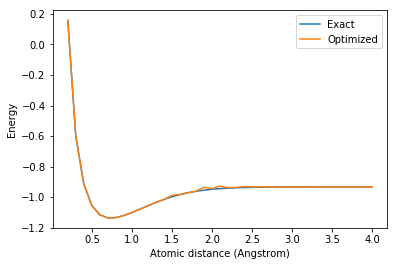

In [6]:
plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
if run_optimization:
    plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()

In [1]:
%run "../version.ipynb"

Package,Version
QISKit,0.4.8
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
